In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
training = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
print(sum(np.sum(pd.isnull(training), axis = 0).tolist()))
# There are no NULL values in training dataset
print(sum(np.sum(pd.isnull(test), axis = 0).tolist()))
# There are no NULL values in test set

0
0


In [6]:
training = training.iloc[:, 1:]
test = test.iloc[:, 1:]

We want to recover from the data loss of the AGA frequency on test samples. Train a regressor which can predict the value of the AGA feature given the remaining ones. Compare different regression algorithms for this task. Since AGA features are missing in test samples, use only the training data for this step and make use of robust evaluation techniques to compare algorithms.

In [7]:
print("Kingdom values: ", np.unique(training["Kingdom"]))
print("DNA type values: ", np.unique(training["DNAtype"]))

Kingdom values:  ['arc' 'bct' 'inv' 'mam' 'phg' 'plm' 'pln' 'pri' 'rod' 'vrl' 'vrt']
DNA type values:  [ 0  1  2  3  4  5  6  7  9 11 12]


#### Function to one-hot encode categorical variables:

In [8]:
def onehot_feature(pd_data, column_name):
    # Retrieve the unique values (the categories) and an index for each sample
    # specifying the sample category (values[value_idx] reconstruct the original array)
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    # Create a temporary identity matrix to convert value_idx into one-hot features
    onehots = np.eye(n_values) #when you use an array to index another array in NumPy, it selects rows from the indexed array based on the values in the index array. e[a] selects rows from the identity matrix e based on the values in array a
    value_onehot = onehots[value_idx]
    # Remove the categorical feature
    pd_data = pd_data.drop(column_name, axis=1)
    # Add the new featues
    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

#### One-hot encoding of both the 'Kingdom' and 'DNAtype' features (on both training and test datasets):

In [9]:
training_ohe = onehot_feature(training, 'Kingdom')
training_ohe = onehot_feature(training_ohe, 'DNAtype')

test_ohe = onehot_feature(test, 'Kingdom')
test_ohe = onehot_feature(test_ohe, 'DNAtype')

training_ohe.head()

,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,CUA,...,DNAtype_1,DNAtype_11,DNAtype_12,DNAtype_2,DNAtype_3,DNAtype_4,DNAtype_5,DNAtype_6,DNAtype_7,DNAtype_9
0,207343,6686,Bovine foamy virus,0.01541,0.00927,0.01720,0.01825,0.01436,0.02303,0.01555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7629,10060,Anthocidaris crassispina,0.01213,0.02515,0.00268,0.01352,0.01372,0.01143,0.00775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,320850,14031,Staphylococcus phage X2,0.02580,0.01618,0.03606,0.01354,0.00848,0.02067,0.01041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1397,39839,Bacillus circulans,0.00128,0.02141,0.01225,0.01649,0.01330,0.01308,0.00399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50790,5112,mitochondrion Dascyllus trimaculatus,0.03169,0.01780,0.03893,0.00000,0.06240,0.01056,0.05262,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Correlation between AGA and each codon and then between each pair of codon

In [10]:
# First let's check if we can use Pearson correlation:

#for col in training.columns[5:]:
#    plt.hist(training.loc[:, col], bins = 10)
#    plt.show()
    
# We can't because they don't follow a gaussian distribution, so we use rank correlation methods like Spearman:

from scipy import stats
print("Codons that have a Spearman correlation >= 0.5 (in absolute terms) with AGA:")
for col in training.columns[5:]:
    if col != 'AGA':
        res = stats.spearmanr(training.loc[:, col], training.loc[:, 'AGA'])
        if abs(res.statistic) >= 0.5:
            print("{}: {} -- p-value = {}".format(col, res.statistic, res.pvalue))

# Now we look at the Spearman correlation between all codons to understand if there's some redundancy:

print("\nPairs of codons with a Spearman correlation >= 0.8 (in absolute terms) NOT considering AGA")
for codon1 in training.columns[5:]:
    for codon2 in training.columns[5:]:
        if codon1 != codon2 and codon1 != 'AGA' and codon2 != 'AGA':
            res = stats.spearmanr( training.loc[:, codon1]    ,  training.loc[:, codon2]    )
        if abs(res.statistic) >= 0.8:
            print("Spearman correlation between {} and {}: {} -- p-value = {}".format(codon1, codon2, res.statistic,
                                                                                     res.pvalue))

Codons that have a Spearman correlation >= 0.5 (in absolute terms) with AGA:
UUG: 0.517733529126989 -- p-value = 0.0
AUC: -0.6633343136412367 -- p-value = 0.0
GCC: -0.7147492089184697 -- p-value = 0.0
CCC: -0.5197634685183508 -- p-value = 0.0
GGC: -0.5852023884920887 -- p-value = 0.0
UCU: 0.5009233407342024 -- p-value = 0.0
AGU: 0.694694113172632 -- p-value = 0.0
UAU: 0.561316082441995 -- p-value = 0.0
AAU: 0.6609476920961472 -- p-value = 0.0
UGU: 0.669400904393223 -- p-value = 0.0
CAU: 0.5266827529444139 -- p-value = 0.0
CAC: -0.5115707636164963 -- p-value = 0.0
AAA: 0.5339363538522637 -- p-value = 0.0
AGG: 0.632327477358485 -- p-value = 0.0
GAU: 0.6161749105450396 -- p-value = 0.0
GAA: 0.5428476518370057 -- p-value = 0.0

Pairs of codons with a Spearman correlation >= 0.8 (in absolute terms) NOT considering AGA
Spearman correlation between UUA and AUU: 0.8367679640170536 -- p-value = 0.0
Spearman correlation between AUU and UUA: 0.8367679640170534 -- p-value = 0.0
Spearman correlatio

#### All functions needed later on:

In [11]:
from scipy.stats import t, f

def rss(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

def multiple_least_squares(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)
    
    se2_b = RSE*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    return df
 
def Ftest_restricted(data, y, subset_features):
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]
    
    betas_complete, y_pred = multiple_least_squares(X_complete, y)    
    rss_complete = rss(y, y_pred)
    nf_complete = X_complete.shape[1]
    
    notS = data.columns.difference(subset_features)
    X_restr = data[notS].to_numpy()
    betas_restr, y_pred = multiple_least_squares(X_restr, y)

    rss_restr = rss(y, y_pred)
    nf_restr = X_restr.shape[1]

    q = nf_complete - nf_restr

    F_num = (rss_restr - rss_complete) / q
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    p_value = f.sf(F, q, n - nf_complete - 1)
    return p_value, F

#### Multivariate linear regression models to understand which codon are useless for predicting AGA frequency
#### Features considered: Codons
#### APPLICA CORREZIONE PER TEST MULTIPLI

In [68]:
from sklearn.linear_model import LinearRegression

X1 = training.iloc[:, 5:].drop("AGA", axis = 1)
y = training.loc[:, "AGA"]

X1_all_features = [col_name for col_name in X1.columns.tolist()]

linear_model1 = LinearRegression(fit_intercept=True)
linear_model1 = linear_model1.fit(X1, y)

betas = np.array([linear_model1.intercept_, *linear_model1.coef_]).reshape(-1, 1) 
final_stats = show_stats(X1.to_numpy(), y.to_numpy(), betas, ['Intercept', *X1_all_features], alpha=0.001)
print(final_stats)
print("\nNOT SIGNIFICANT CODONS:\n ", final_stats[final_stats.loc[:, 'reject H0']==False])

         Name  Coefficients  Standard Errors        t-stat  p-value  reject H0
0   Intercept      0.999938         0.000082  12248.651521      0.0       True
1         UUU     -0.999900         0.000088 -11419.511160      0.0       True
2         UUC     -0.999959         0.000101  -9905.781604      0.0       True
3         UUA     -0.999960         0.000096 -10412.822448      0.0       True
4         UUG     -0.999897         0.000103  -9710.379087      0.0       True
..        ...           ...              ...           ...      ...        ...
59        GAA     -0.999955         0.000103  -9738.646816      0.0       True
60        GAG     -0.999950         0.000100 -10007.550693      0.0       True
61        UAA     -0.999893         0.000088 -11412.835860      0.0       True
62        UAG     -0.999394         0.000435  -2295.279831      0.0       True
63        UGA     -1.000029         0.000133  -7535.083484      0.0       True

[64 rows x 6 columns]

NOT SIGNIFICANT CODONS:
  Em

#### Multivariate linear regression models to understand which codon are useless for predicting AGA frequency
#### Features considered: Codons, Kingdom and DNAtype

#### Se consideriamo tutti i livelli della dummy variable "DNAtype" la funzione dà NaN per gli SE dei coefficienti --> può aver senso rimuovere i livelli della variabile che hanno troppe poche osservazioni (1 sola) dato che questo porta sicuramente ad una stima non precisa del coefficiente

In [21]:
X2 = training_ohe.drop(["AGA", "SpeciesName", "SpeciesID", "Ncodons", "DNAtype_11"], axis = 1)
y = training_ohe.loc[:, "AGA"]

X2_all_features = X2.columns.tolist()

linear_model2 = LinearRegression(fit_intercept=True)
linear_model2 = linear_model2.fit(X2, y)

betas = np.array([linear_model2.intercept_, *linear_model2.coef_]).reshape(-1, 1) 
final_stats = show_stats(X2.to_numpy(), y.to_numpy(), betas, ['Intercept', *X2_all_features], alpha=0.001)


print(final_stats)
print("\nNOT SIGNIFICANT FEATURES: \n", final_stats[final_stats.loc[:, 'reject H0']==False])

         Name  Coefficients  Standard Errors        t-stat   p-value  \
0   Intercept      0.999936        75.653152      0.013217  0.989455   
1         UUU     -0.999914         0.000091 -11002.918357  0.000000   
2         UUC     -0.999983         0.000105  -9561.039824  0.000000   
3         UUA     -0.999972         0.000101  -9931.372048  0.000000   
4         UUG     -0.999911         0.000105  -9492.038515  0.000000   
..        ...           ...              ...           ...       ...   
80  DNAtype_4      0.000006         0.000039      0.155761  0.876224   
81  DNAtype_5      0.000028         0.000054      0.522845  0.601093   
82  DNAtype_6      0.000048         0.000054      0.878556  0.379662   
83  DNAtype_7      0.000055         0.000055      1.002649  0.316054   
84  DNAtype_9     -0.000031         0.000047     -0.666865  0.504874   

    reject H0  
0       False  
1        True  
2        True  
3        True  
4        True  
..        ...  
80      False  
81     

In [32]:
print(np.sum(training_ohe.loc[:, "DNAtype_1":], axis = 0), '\n')

print(np.sum(training_ohe.loc[:, "Kingdom_arc":"Kingdom_vrt"], axis = 0))

DNAtype_1     2320.0
DNAtype_11       1.0
DNAtype_12       5.0
DNAtype_2      658.0
DNAtype_3        2.0
DNAtype_4       24.0
DNAtype_5        1.0
DNAtype_6        1.0
DNAtype_7        1.0
DNAtype_9        2.0
dtype: float64 

Kingdom_arc     101.0
Kingdom_bct    2336.0
Kingdom_inv    1076.0
Kingdom_mam     458.0
Kingdom_phg     176.0
Kingdom_plm      14.0
Kingdom_pln    2018.0
Kingdom_pri     144.0
Kingdom_rod     172.0
Kingdom_vrl    2265.0
Kingdom_vrt    1662.0
dtype: float64


#### Performance of the model with only the codons


In [83]:
from sklearn.metrics import r2_score, mean_squared_error

y_predict = linear_model1.predict(X1)
print("Train R2 score ", r2_score(y, y_predict))
print("Train MSE score ", mean_squared_error(y, y_predict))

Train R2 score  0.9999803188956894
Train MSE score  1.4547727981251517e-09


#### Check that 'DNAtype' and 'Kingdom' features are actually useless to predict AGA frequency
By looking at the p-value, we can exclude those features.

In [33]:
features_to_exclude = X2.loc[:, "Kingdom_arc":].columns.tolist()

p_value, F = Ftest_restricted(X2, y, features_to_exclude)
print("p-value =", p_value)
print("F-stat =", F)
if p_value < 0.001:
    print("Reject H0: There is evidence to say that at least one of the S features is useful")
else:
    print("Do not Reject H0: There is NO evidence to say that at least one of the S features is useful")


p-value = 0.6378232098784188
F-stat = 0.8655025713324493
Do not Reject H0: There is NO evidence to say that at least one of the S features is useful


### Plots for Goodness of Fit

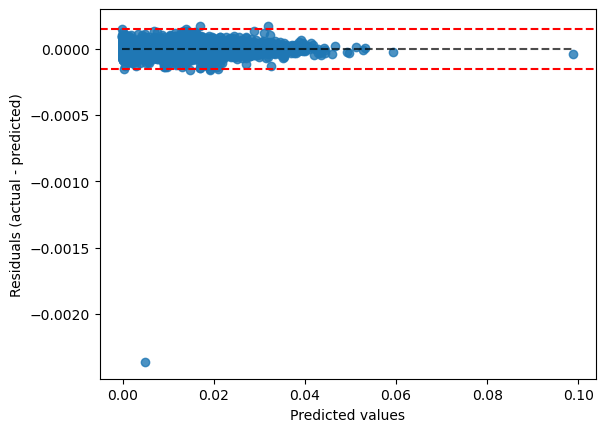

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import PredictionErrorDisplay

# Supponendo che y e y_predict siano già definiti
display = PredictionErrorDisplay(y_true=y, y_pred=y_predict)
display.plot()

# Definisci epsilon come lo scarto desiderato
epsilon = 0.00015  # Modifica questo valore a seconda delle tue esigenze

# Aggiungi le curve orizzontali
plt.axhline(y=epsilon, color='r', linestyle='--')
plt.axhline(y=-epsilon, color='r', linestyle='--')

plt.show()

# Il punto 239 è un outlier ma solo relativamente agli altri perché comunque è un errore, in termini assoluti, bassissimo.


### Ridge vs Lasso
#### In theory, Lasso performs better when we expect only few features to be significant. In this case we expect a lot of features to be useful (almost all the codons) so probably Ridge is better (try both but with this premise)
#### Don't forget about Elastic Net

#### Ridge, with CV

In [59]:
from sklearn.linear_model import RidgeCV
X = training.iloc[:, 5:].drop("AGA", axis = 1)
y = training.loc[:, "AGA"]

ridge_linear_model = RidgeCV(alphas=[1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4,
                                    1e-3, 1e-2, 1e-1, 1], fit_intercept = True).fit(X, y)
ridge_linear_model.score(X, y)
ridge_linear_model.alpha_ # Regolarizza poco

ridge_linear_model.coef_

array([-0.99989797, -0.99996219, -0.99995972, -0.99989169, -0.99982781,
       -0.99988873, -1.00016744, -0.9999523 , -0.99984709, -0.99999328,
       -0.99983637, -1.00001541, -0.9999014 , -1.00001455, -0.99985913,
       -0.99985732, -0.99986552, -0.9998667 , -0.99997477, -1.00010244,
       -1.00001627, -0.99985158, -1.00006516, -0.99980884, -0.9999665 ,
       -0.99992212, -0.99993883, -0.99993559, -0.99983292, -1.00069803,
       -0.9998157 , -0.99987106, -0.99990506, -0.99982157, -0.99992948,
       -0.99981355, -0.99992822, -0.99987199, -0.99989004, -1.00015756,
       -0.99983644, -0.99984315, -0.99996281, -0.99992119, -0.99990003,
       -0.9997493 , -1.00020639, -0.99972808, -1.0001158 , -0.99990369,
       -0.99995385, -1.00012177, -0.99990176, -0.9997737 , -1.00004166,
       -0.99979269, -0.99997852, -0.99990102, -0.99995236, -0.99994566,
       -0.99989263, -0.99939341, -1.00003447])

In [60]:
y_predict = ridge_linear_model.predict(X)
print("Train R2 score ", r2_score(y, y_predict))
print("Train MSE score ", mean_squared_error(y, y_predict))

Train R2 score  0.9999803050407857
Train MSE score  1.4557969142875978e-09


#### Lasso, with CV

In [51]:
from sklearn.linear_model import LassoCV
X = training.iloc[:, 5:].drop("AGA", axis = 1)
y = training.loc[:, "AGA"]

lasso_linear_model = LassoCV(cv=10, random_state=0, max_iter=10000).fit(X, y)
lasso_linear_model.score(X, y)

for idx,coef in enumerate(lasso_linear_model.coef_):
    if abs(coef) != 0:
        print("Coefficient of {}: {}".format(X.columns[idx], coef))
    else:
        print("Coefficient {} was removed".format(X.columns[idx]))


Coefficient of UUU: -0.7168874897846788
Coefficient of UUC: -0.7234332902857926
Coefficient of UUA: -0.7049619251318686
Coefficient of UUG: -0.712573469936141
Coefficient of CUU: -0.7314289854985274
Coefficient of CUC: -0.7178467046501648
Coefficient of CUA: -0.7313261657987461
Coefficient of CUG: -0.7042662807933477
Coefficient of AUU: -0.7333441018946949
Coefficient of AUC: -0.730962896696767
Coefficient of AUA: -0.7010507109563723
Coefficient of AUG: -0.7074365698869282
Coefficient of GUU: -0.716996319559336
Coefficient of GUC: -0.7055912840681621
Coefficient of GUA: -0.7069038948003306
Coefficient of GUG: -0.7247373567052868
Coefficient of GCU: -0.7154356585308953
Coefficient of GCC: -0.7295541687151093
Coefficient of GCA: -0.7255497453890111
Coefficient of GCG: -0.7063432918216672
Coefficient of CCU: -0.7153344398284471
Coefficient of CCC: -0.7127368588616687
Coefficient of CCA: -0.7065376530253261
Coefficient of CCG: -0.7164461231593272
Coefficient of UGG: -0.6762671759793442
Coe

In [61]:
y_predict = lasso_linear_model.predict(X)
print("Train R2 score ", r2_score(y, y_predict))
print("Train MSE score ", mean_squared_error(y, y_predict))

Train R2 score  0.9769411799917588
Train MSE score  1.7044442006670613e-06


### Forward feature selection
### because there are too many variables to use the Best Subset feature selection

In [73]:
def get_evaluator(scorer): 
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator    

def estimate_sigma(Xtrain_pd, ytrain):
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    return scorer

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))

In [76]:
from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1] # Number of features
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    plt.figure()
    candidate_fig = plt.subplot(111) # A global matplotlib figure
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2.
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    # Complete the subsets_fig figure by plotting
    # a line connecting all best candidate score
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    # Plot a figure to show how te 3. metric evolves
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

............
Best model (M0) with 1 features: ['GCC']
M0 subset score (3.): 0.4086362316528077
............
Best model (M1) with 2 features: ['GCC', 'AGG']
M1 subset score (3.): 0.55108801884796
............
Best model (M2) with 3 features: ['GCC', 'AGG', 'AAU']
M2 subset score (3.): 0.6075515425817029
............
Best model (M3) with 4 features: ['GCC', 'AGG', 'AAU', 'GAA']
M3 subset score (3.): 0.6296723615941588
............
Best model (M4) with 5 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU']
M4 subset score (3.): 0.6408028751560824
............
Best model (M5) with 6 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC']
M5 subset score (3.): 0.6583101764204625
............
Best model (M6) with 7 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA']
M6 subset score (3.): 0.6665483448161754
............
Best model (M7) with 8 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA', 'GGA']
M7 subset score (3.): 0.6758322135433735
............
Best model (M8) with 9 features: 

............
Best model (M37) with 38 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA', 'GGA', 'AUU', 'ACG', 'AGC', 'CUU', 'GGG', 'GGC', 'CUA', 'AUA', 'UGG', 'UAC', 'UGC', 'UCA', 'GUG', 'UAU', 'ACA', 'UUC', 'CAA', 'GAU', 'CCG', 'GAC', 'CCC', 'GGU', 'AAC', 'CUC', 'CGC', 'UAA', 'GUU', 'UUU', 'ACC', 'GCU']
M37 subset score (3.): 0.7320298493824536
............
Best model (M38) with 39 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA', 'GGA', 'AUU', 'ACG', 'AGC', 'CUU', 'GGG', 'GGC', 'CUA', 'AUA', 'UGG', 'UAC', 'UGC', 'UCA', 'GUG', 'UAU', 'ACA', 'UUC', 'CAA', 'GAU', 'CCG', 'GAC', 'CCC', 'GGU', 'AAC', 'CUC', 'CGC', 'UAA', 'GUU', 'UUU', 'ACC', 'GCU', 'CAG']
M38 subset score (3.): 0.734481204159491
............
Best model (M39) with 40 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA', 'GGA', 'AUU', 'ACG', 'AGC', 'CUU', 'GGG', 'GGC', 'CUA', 'AUA', 'UGG', 'UAC', 'UGC', 'UCA', 'GUG', 'UAU', 'ACA', 'UUC', 'CAA', 'GAU', 'CCG', 'GAC', 'CCC', 'GGU', 'AAC', 'CUC', 'CGC', 

............
Best model (M57) with 58 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA', 'GGA', 'AUU', 'ACG', 'AGC', 'CUU', 'GGG', 'GGC', 'CUA', 'AUA', 'UGG', 'UAC', 'UGC', 'UCA', 'GUG', 'UAU', 'ACA', 'UUC', 'CAA', 'GAU', 'CCG', 'GAC', 'CCC', 'GGU', 'AAC', 'CUC', 'CGC', 'UAA', 'GUU', 'UUU', 'ACC', 'GCU', 'CAG', 'CAU', 'GAG', 'UUG', 'CAC', 'UUA', 'AAG', 'CGG', 'CCU', 'CUG', 'UCG', 'AAA', 'CCA', 'ACU', 'GUC', 'GUA', 'UCU', 'AUG', 'UCC', 'GCG']
M57 subset score (3.): 0.8013350839753816
............
Best model (M58) with 59 features: ['GCC', 'AGG', 'AAU', 'GAA', 'CGU', 'AUC', 'GCA', 'GGA', 'AUU', 'ACG', 'AGC', 'CUU', 'GGG', 'GGC', 'CUA', 'AUA', 'UGG', 'UAC', 'UGC', 'UCA', 'GUG', 'UAU', 'ACA', 'UUC', 'CAA', 'GAU', 'CCG', 'GAC', 'CCC', 'GGU', 'AAC', 'CUC', 'CGC', 'UAA', 'GUU', 'UUU', 'ACC', 'GCU', 'CAG', 'CAU', 'GAG', 'UUG', 'CAC', 'UUA', 'AAG', 'CGG', 'CCU', 'CUG', 'UCG', 'AAA', 'CCA', 'ACU', 'GUC', 'GUA', 'UCU', 'AUG', 'UCC', 'GCG', 'AGU']
M58 subset score (3.): 0.8191286637672119

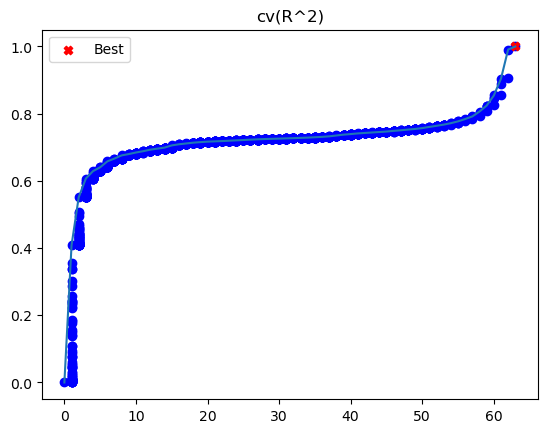

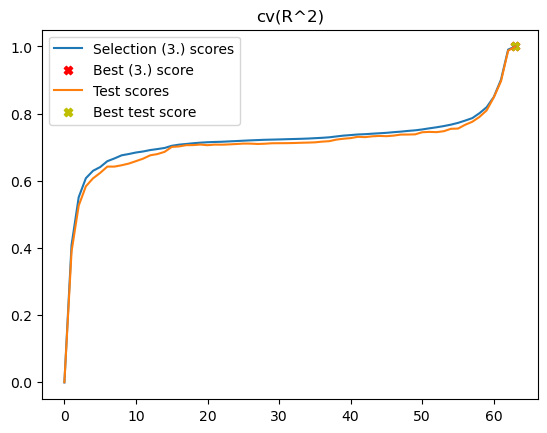

In [82]:
X_train_pd, X_test_pd, y_train, y_test = train_test_split(training.iloc[:, 5:].drop("AGA", axis = 1), 
                                                          training.loc[:, "AGA"], 
                                                          test_size=0.3, random_state=12)

sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score), cv=10), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

#### Notice that the first selected features are the codons which correlate (Spearman correlation) the most with the response codon AGA